# Set up an interactive map in browser in a few steps



### Customize a map with your points and share with ease

PyCon SK 2022

Vojta Filipec

## Abstract
Maps are popular means to visualise geospatial data. Companies often possess datapoints with latitute and longitude; nonetheless, data analysts typically lack skills to visualise this data as a map. This talk explains how to set up a map with your custom data in a web browser. We are going to talk about library `folium` that takes care of renderring the map, and how to feed your custom data into it. 


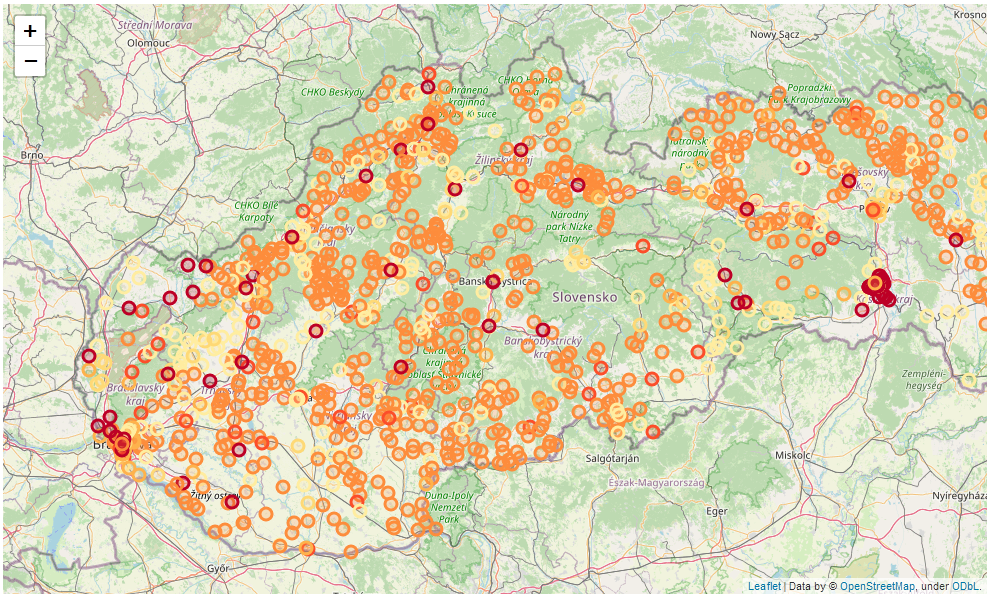


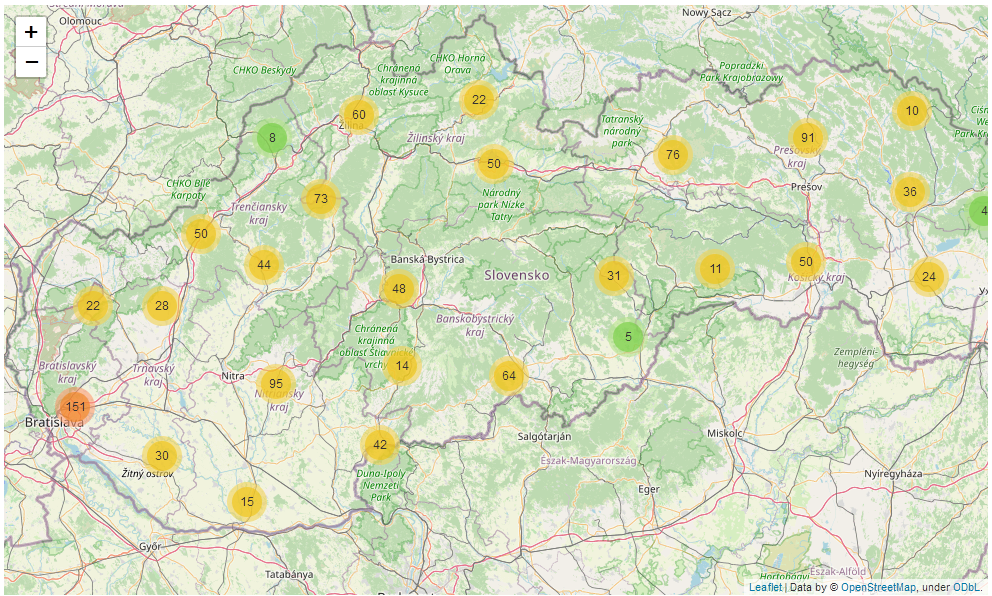


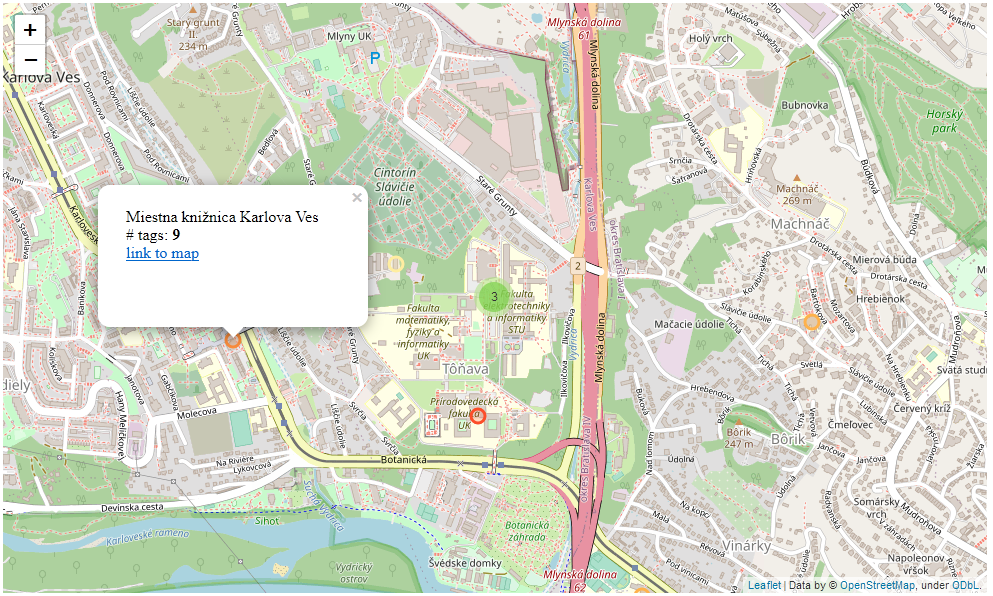

## Aboutme

☢ nuclear physicist

⨋ data scientist 

✉ linkedin.com/in/vojtech-filipec/

㏚ github.com/vojtech-filipec/

## Typical dataset with lat/longs


|ID   | latitude | longitude   | object name | # users | (other properties) |
|-----|----------|-----------|--------------| ------   | ------   | 
| 0   | 17.269668    |48.284123    |Malokarpatská knižnica v Pezinku  | 980 | ... | 
|1    | 17.256186    |48.187381    |Obecná knižnica Ivanka pri Dunaji | 1100| ...|
|2    |	22.146649    |48.985100    |Mestská knižnica Snina 	    |   1500 | ...|
|3    |	19.668956    |48.328798    |Novohradská knižnica 	    |   754 | ...|
|4    |	18.272445    |47.868790    |Obecná knižnica Dulovce    |    222 | ...|
| ... | ...           | ...        | ...                           | ... | ...|
|high N    |	21.372445    |48.068790    |Yet another library    | 883| ...|


To visualize this:
* project these locations to a map
* use colour/size/shape for properties of the locations
* display additional text for details

POIs = Points Of Interest = customer addresses, retail branches, trip destinations, ...

# Structure of the talk

0\. Preparations: download all libraries in Slovakia 

1\. Use-case #1: Plot a set of POIs
- via `matplotlib`
- via `folium`
- a few hacks for `folium`
    
2\. Use-case #2: Chorophlet map
- via Uber's `h3` + `folium`



# Preparations

goal: use The OpenStreetMap to download all libraries in Slovakia

In [ ]:
import requests
import overpy

api = overpy.Overpass()

qry_libraries = """
(area["ISO3166-1"="SK"];) ->.slovakia;
nwr["amenity"="library"](area.slovakia);
out tags center;
"""
res = api.query(qry_libraries)

details: refer to Appendix

In [ ]:
print(len(res.nodes))
print(len(res.ways))
print(len(res.relations))

The counts are correct: verify at https://taginfo.geofabrik.de/europe/slovakia/tags/amenity=library

In [ ]:
coords  = []
coords += [(node.id,
            'node',
            float(node.lon), 
            float(node.lat),
            dict(node.tags).get('name', "(missing name)"),
            dict(node.tags)
           ) 
           for node in res.nodes]
coords += [(way.id,
            'way',
            float(way.center_lon), 
            float(way.center_lat),
            dict(way.tags).get('name', "missing name"),
            dict(way.tags)
           )     
           for way in res.ways]
coords += [(rel.id,
            'relation',
            float(rel.center_lon), 
            float(rel.center_lat),
            dict(rel.tags).get('name', "missing name"),
            dict(rel.tags)
           ) 
           for rel in res.relations]

In [ ]:
coords[:2]

structure of our data: a list of tupples as follows: 

```
(54583383,                                         # object ID
  'node',                                          # object type: node, way, relation
  17.2561859,                                      # longitude
  48.1873807,                                      # latitude
  'Obecná knižnica Ivanka pri Dunaji',             # name
  {'addr:city': 'Ivanka pri Dunaji',               # tags
   'addr:housenumber': '25',
   'addr:postcode': '900 28',
   'addr:street': 'Štefánikova',
   'addr:streetnumber': '25',
   'amenity': 'library',
   'contact:email': 'starosta@ivankapridunaji.sk',
   'contact:phone': '+421 910 999 190',
   'name': 'Obecná knižnica Ivanka pri Dunaji',
   'source:name': 'www.ivankapridunaji.sk'})
```


verify: https://www.openstreetmap.org/node/54583383

In [ ]:
import pickle
with open('slovak-libraries.pkl', 'wb') as pickle_file:
    pickle.dump(coords, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from IPython.display import HTML, display
import pandas as pd
pd.set_option("display.max_columns", None)
# pd.get_option("display.max_columns")

In [ ]:
import pickle

with open('slovak-libraries.pkl', 'rb') as pickle_load:
    ds_comm = pickle.load(pickle_load)

In [ ]:
# convert the list to data frame
df_libs = pd.DataFrame(ds_comm, columns=['object_id','object_type','lon','lat','library_name','tags'])
df_libs['cnt_tags'] = df_libs['tags'].apply(lambda x: len(x))

In [ ]:
df_libs.drop('hex5', inplace=True, errors='ignore')

In [ ]:
display(df_libs.head())
display(df_libs.shape)

`object_type` and `object_id` define the URL in The OpenStreetMap: e.g. https://www.openstreetmap.org/node/54583383

# Use-case #1: Plot a set of POIs

- via `matplotlib`
- via `folium`
- a few hacks for `folium`

## Option #1: a plain `matplotlib` scatterplot by lat/long

In [ ]:
df_libs.head()

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')

plt.scatter(df_libs['lon'], df_libs['lat'])
plt.show()

This can be enhanced:
- display a baloon with library name
- display large cities or borders

But this complicates the code + how to project on a real map --> try another approach.

# (cont.: Use-case #1: Plot a set of POIs)

## Option #2: use `folium`


In [ ]:
import folium
from plot_functions import *

In [ ]:
first_map = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap')

for row in df_libs.itertuples():
    folium.CircleMarker(
        location=[row.lat, row.lon], 
        radius=6,
        fill=True,
        color=create_color(row),
        popup=create_popup(row)
    ).add_to(first_map)

In [ ]:
display(first_map)

- map

- location of Markers (for points of interest)

- for each Marker: colour + pop-up text

### Map

In [ ]:
import folium

In [ ]:
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap') 
display(m)

* mind the order: [latitude, longitude], ie the way you say it:
```python
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap') 
```


* more Map options: https://python-visualization.github.io/folium/modules.html#folium.folium.Map

### Markers

In [ ]:
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap')

In [ ]:
for row in df_libs.itertuples():
    folium.CircleMarker(                 # marker name
        location=[row.lat, row.lon],     # marker location, mind the order: [Y, X], ie [latitude, longitude]
        radius=6,
        fill=True
    ).add_to(m)

display(m)    

### Color to encode the number of tags

In [ ]:
df_libs['cnt_tags'].describe()

```python 
def create_color(row):
    if row.cnt_tags < 5:
        color = '#ffeda0' # '#FFEDA0' works too, yellow
    elif row.cnt_tags < 7:
        color = '#fed976'
    elif row.cnt_tags < 9:
        color = '#feb24c'
    elif row.cnt_tags < 11:
        color = '#fd8d3c'
    elif row.cnt_tags < 13:
        color = '#fc4e2a'
    else:
        color = '#bd0026'  #darkred
    return color
```

In [ ]:
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap')

In [ ]:
for row in df_libs.itertuples():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=6,
        fill=True,
        color=create_color(row)      # COLOR 
    ).add_to(m)

display(m)    

* 6 scaled values: 'darkblue', 'blue', 'lightblue', 'lightgreen','green','beige' 
* 19 values: 'red', 'blue', 'green', 'purple', 'orange', 'darkred',
 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
 'gray', 'black', 'lightgray'
* hexidecimal codes work

Generate your color scale: https://hihayk.github.io/scale

### Define pop-up  text

```python 
def create_popup(row):    
    return folium.Popup(folium.IFrame("""
        {name} 
        <br>
        # tags: <b> {cnt} </b>
        <br>
        <a href="https://www.openstreetmap.org/{object_type}/{object_id}">link to OSM detail</a>
        """.format(name= row.library_name, 
                   cnt = row.cnt_tags,
                   object_type = row.object_type,
                   object_id = row.object_id), 
                        width=450, height=110))
```

In [ ]:
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap')

for row in df_libs.itertuples():
    folium.CircleMarker(
        location=[row.lat, row.lon], 
        radius=6,
        fill=True,
        color=create_color(row),           
        popup=create_popup(row)            # POPUP
    ).add_to(m)

display(m)

## A few hacks to folium

### Available maps:

`folium.Map(tiles= ...)`

* “OpenStreetMap”
* “Mapbox Bright” (Limited levels of zoom for free tiles)
* “Mapbox Control Room” (Limited levels of zoom for free tiles)
* “Stamen” (Terrain, Toner, and Watercolor)
* “Cloudmade” (Must pass API key)
* “Mapbox” (Must pass API key)
* “CartoDB” (positron and dark_matter)

https://python-visualization.github.io/folium/modules.html

In [ ]:
def show_100_libraries(tiles_source, df_libraries=df_libs):
    m = folium.Map(location=[df_libraries.lat.mean(), df_libraries.lon.mean()], zoom_start=8, tiles=tiles_source)
    
    for row in df_libs.head(100).itertuples():
        folium.CircleMarker(
            location=[row.lat, row.lon],
            radius=4
        ).add_to(m)
        
    display(m)

In [ ]:
show_100_libraries('CartoDB positron')

In [ ]:
show_100_libraries('Stamen Toner')

In [ ]:
show_100_libraries('Stamen Terrain')

### `Marker` vs. `CircleMarker`

In [ ]:
# ?folium.CircleMarker
# ?folium.Marker

In [ ]:
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=8, tiles='OpenStreetMap')

for row in df_libs.itertuples():
    folium.Marker(
        location=[row.lat, row.lon], 
        icon=folium.Icon(icon='book')   # <---- specify the icon 
    ).add_to(m)

display(m)


* more icons at [https://fontawesome.com/](https://fontawesome.com/v4/icons/)

### grouping of Markers

In [ ]:
from folium.plugins import MarkerCluster 

In [ ]:
m = folium.Map(location=[df_libs.lat.mean(), df_libs.lon.mean()], zoom_start=9, tiles='OpenStreetMap')

marker_cluster = MarkerCluster(control=False).add_to(m)  # <<<<<

for row in df_libs.itertuples():
    folium.CircleMarker(
        location=[row.lat, row.lon],
        radius=7,
        fill=True,
        color=create_color(row),
        popup=create_popup(row)
    ).add_to(marker_cluster) # <<<<<
display(m)

# Use-case #2: Chorophlet map
- via Uber's `h3` + `folium`

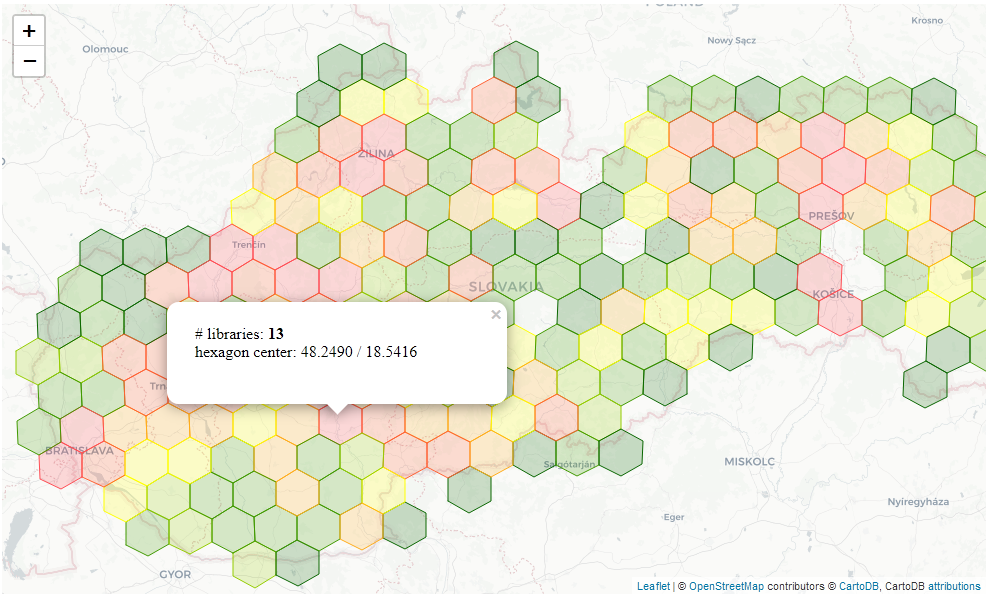

**chorophlet map** ("kartogram" in CZ/SK) uses a color to visualize the aggregated summary of points within each area

Unlike plotting single POIs, a **chorophlet map** ("kartogram" in CZ/SK) visualizes property of an area: 
- population density, 
- per-capita income,
- prevailing type of surface,
- range of a species, 
- count of libraries.



Folium offers chorophlet maps: 
* intro: https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps 
* gallery: https://nbviewer.org/github/python-visualization/folium_contrib/tree/master/notebooks/

**extension:** Uber's `h3`

### About Uber's `h3`

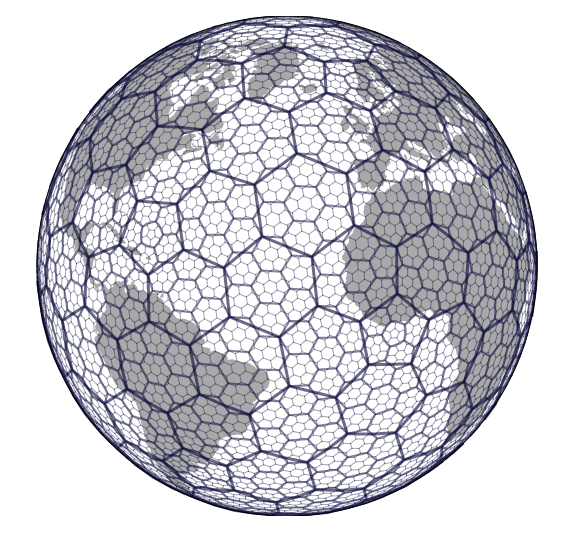

- intro and motivation by Uber: https://eng.uber.com/h3/
- library docs: https://h3geo.org/
- hierarchy: https://h3geo.org/images/pentagon_hexagon_children.png

In [ ]:
import h3

In [ ]:
import os
u3_hexagons = pd.read_csv(os.path.join('.', 'h3-properties.txt'), sep=r'\t', engine='python', thousands=',', index_col='resolution')

In [ ]:
# source: https://h3geo.org/docs/core-library/restable
u3_hexagons

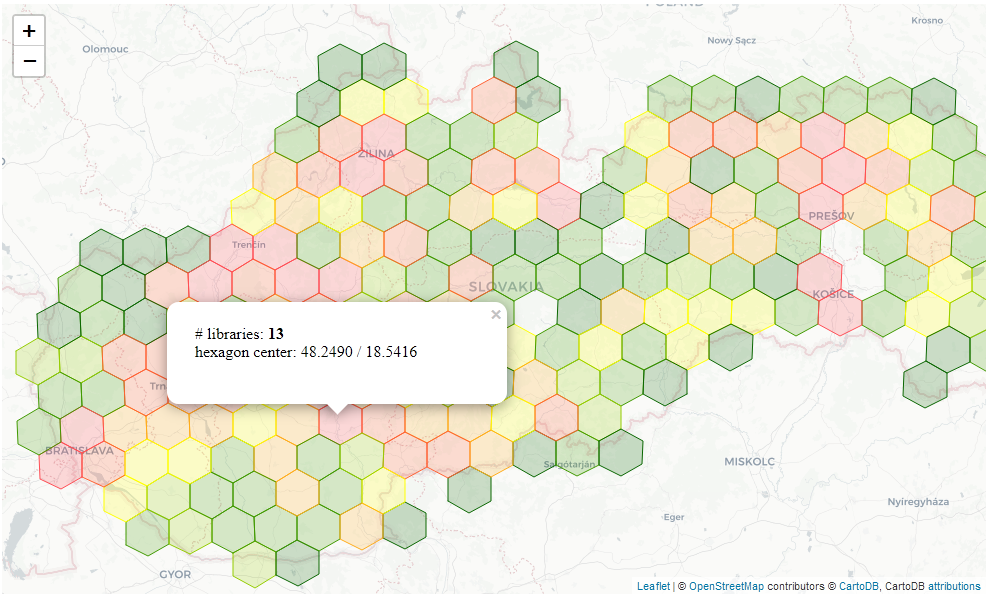

- [lat, lon] of a library $\mapsto$ hexagon_ID: `h3.geo_to_h3(latitude,longitude,resolution)`

- group by hexagon_ID

- hexagon_ID $\mapsto$ [lat, lon] of its center: `h3.h3_to_geo(hexagon_ID)`

In [ ]:
h3_level = 5
hex_col = 'hex'+str(h3_level)

# [lat, lon] of a library into hexagon_ID: `
df_libs[hex_col] = df_libs.apply(lambda x: h3.geo_to_h3(x.lat,x.lon,h3_level), 1)

# group to hexagons
df_libs_g = df_libs.groupby(hex_col).size().to_frame('cnt_libraries').reset_index()

#find center of hexagon for visualization
df_libs_g['lat'] = df_libs_g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_libs_g['lon'] = df_libs_g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

In [ ]:
display(df_libs_g.head())
display(df_libs_g.shape)

In [ ]:
df_libs_g.shape

colours and pop-ups:
* \# libraries and its center
* (code as before)

In [ ]:
df_libs_g['cnt_libraries'].value_counts().sort_index()

In [ ]:
df_libs_g.cnt_libraries.quantile([.15, .30, .45, .60, .75, 0.9, 1])

In [ ]:
def create_color_chorophlet(row):
    if row.cnt_libraries < 2:
        color = '#0A6600'
    elif row.cnt_libraries < 4:
        color = '#419900'
    elif row.cnt_libraries < 5:
        color = '#94cc00'
    elif row.cnt_libraries < 6:
        color = '#ffff00'
    elif row.cnt_libraries < 9:
        color = '#ffac1a'
    elif row.cnt_libraries < 12:
        color = '#ff6133'
    else:
        color = '#ff4d54'
    return color


def create_popup_chorophlet(row):    
    return Popup(IFrame("""
        # libraries: <b> {cnt} </b>
        <br>
        hexagon center: {lat} / {lon}
        """.format(lat='{:2.4f}'.format(row.lat), 
                   lon='{:2.4f}'.format(row.lon),
                   cnt = row.cnt_libraries), 
                        width=300, height=70))

In [ ]:
# from h3 import h3
# import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    
    source: https://nbviewer.jupyter.org/github/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)   # Create a polygon describing the outline of a hexagons.
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=8, tiles='CartoDB positron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color=color,popup=create_popup_chorophlet(row),fill_color=color)
        m.add_child(my_PolyLine)
    return m

In [ ]:
m = folium.Map(location=[df_libs_g.lat.mean(), df_libs_g.lon.mean()], zoom_start=7, tiles='CartoDB positron')

for i in df_libs_g.index:
    row = df_libs_g.loc[i]
    m = visualize_hexagons([row[hex_col]], color=create_color_chorophlet(row), folium_map=m)

display(m)
# source: https://nbviewer.jupyter.org/github/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb

### Thank you for attention

✉ linkedin.com/in/vojtech-filipec/

㏚ github.com/vojtech-filipec/

# Appendix

## About `h3` 
install as usual: via conda-forge, or pip

`h3` visualization resources:

- https://nbviewer.jupyter.org/github/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb
- https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

## OpenStreetMap API and its query language

refer to my PyConCZ 2020 talk: https://github.com/vojtech-filipec/PyConCZ-OSM-API

## The count of libraries in Slovakia

It seems the OSM contains only a subset of all libraries, as this source https://www.infolib.sk/sk/kniznice/adresare/zoznam-kniznic-sr/ describes more than 3000 libraries.


## Geopandas, geodataframes, geometries

We skipped this: a library `geopandas` follows the standard `pandas` API while offering useful operations with geometries.

https://geopandas.org/en/stable/

## Other geo-visualization libraries 

A nice overview in Towards Data Science: https://towardsdatascience.com/the-battle-of-interactive-geographic-visualization-part-5-folium-cc2213d29a7